<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl


from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io

WEIGHTSANDBIASES = True
DOWNLOAD = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'

# from google.colab import drive
# drive.mount('/content/drive')

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [162]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [163]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [164]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [165]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  print(train_data.__getdist__())
  print(train_data.len)

  return train_data, test_data,validation_data


In [166]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [167]:
def get_weights():
  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1



  weights[1] *= 2.0
  weights[3] *= 2.0
  weights[4] *= 2.0


  weights = weights / weights.sum()


  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4])

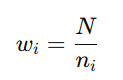

[0.00657042, **0.03958192**, 0.04008614, **0.08570948**, **0.13472377**, 0.31024417,
 0.3830841 ]

 provarem a augmentar en 1.5 els pesos de les enfermetats perilloses:

[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052,
 0.33901021]

 i en 2.0:

 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257,
 0.30403135]

 Això pujarà el pes conjunt de les classes perilloses fins a 41%

In [168]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [169]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  elif numero_model == 1:
    vggbinary = models.vgg19(weights=weights)
    vggbinary.classifier[6] = nn.Linear(in_features=4096, out_features=1)
    loss_fn = nn.BCEWithLogitsLoss(weights = weights)

    return vggbinary,loss_fn

  elif numero_model == 2:
    # alexnetmulticlass = models.alexnet(weights=None)

    # alexnetmulticlass.classifier = nn.Sequential(
    # torch.nn.Linear(9216, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 512),
    # nn.ReLU(),
    # torch.nn.Linear(512, 7),  # Ja que tenim 7 classes.
    # nn.Softmax(dim=1)
    # )
    # loss_fn = nn.CrossEntropyLoss()

    # return alexnetmulticlass,loss_fn
    return




In [170]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [171]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
        target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
        target = target.to(device)


        input_img = input_img.to(device)
        output = model(input_img.to(device))

        loss = loss_fn(output, target.float())

        output = torch.sigmoid(output)

        output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,zero_division=1)
        train_recall += recall_score(target,output,zero_division=1)
        train_precision += precision_score(target,output,zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [172]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):
            input_img = input_img.to(device)


            target = torch.unsqueeze(target, 1)
            target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
            target = target.to(device)

            output = model(input_img)
            loss = loss_fn(output, target.float())

            output = torch.sigmoid(output)
            output = (output.cpu().detach().numpy() > 0.5).astype(int)
            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,zero_division=1)
            val_recall += recall_score(target,output,zero_division=1)
            val_precision += precision_score(target,output,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [173]:
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)
  architecrures_inv = {0: 'alexnet',1:'vgg',2:'resnet'}

  patiente = 100
  best_recall = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)

      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

        # torch.save(model, "my_model.pt")
        # wandb.log_model("./my_model.pt", architecrures_inv[MODEL], aliases=[f"epoch-{epoch+1}"])

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_reall: {val_recall}")

      if val_recall > best_recall:
        best_recall = val_recall
        patiente = 100
      else:
        patiente -= 1

      if patiente == 0:
        print("Early Sopping")
        break

  wandb.finish()

In [174]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'vgg': 1,'resnet': 2}
MODEL = architectures['alexnet']

TRAINING = 0.75
VALIDATION = 0.15
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
#FINE_TUNING = [None,models.AlexNet_Weights.IMAGENET1K_V1]
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    #transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

#load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)

#Realitzar el tuning de hiperparàmetres aquí


EPOCHS = 50
batch_size = 32

#[0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841 ]
# WEIGHTS = [[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021],
#  [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]]

#WEIGHTS = [2.33,1.5]

WEIGHTS = [get_weights(),2.0]

learning_rate  = 1e-4

for weights in product(WEIGHTS):

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  model,loss_fn = tria_model(MODEL,weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  projectes = ['Ham10000-AlexnetBinary','Ham1000-Vgg','Ham1000-ResNet']

  #print(f"{batch_size} , {weights} , {learning_rate}")
  if WEIGHTSANDBIASES:
      wandb.init(
              project=projectes[MODEL],
              config={
                  "epochs": EPOCHS,
                  "batch_size": batch_size,
                  "lr": learning_rate,
                  "trsize":len(train_loader),
                  "trdist":TRAINING,
                  "vsize":len(val_loader),
                  "vdist":VALIDATION,
                  "weights":weights,
                  })
      config = wandb.config
      print(config)

  execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)

0    5028
1     835
2     824
3     386
4     245
5     106
6      86
Name: count, dtype: int64
7510
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


{'epochs': 50, 'batch_size': 32, 'lr': 0.0001, 'trsize': 235, 'trdist': 0.75, 'vsize': 32, 'vdist': 0.15, 'weights': [1.4229647861576398]}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.4426979942524687
Accuracy train epoch: 1  train_acc: 0.8250362669245648
F1 train epoch: 1  train_f1: 0.466216381556306
Recall train epoch: 1  train_recall: 0.48122669292882025


Pèrdua validació epoch: 1  val_loss: 0.3936200998723507
Accuracy val epoch: 1  val_acc: 0.85546875
F1 val epoch: 1  val_f1: 0.49718959553518377
Recall val epoch: 1  val_reall: 0.40721613455988465


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.37487551842598205
Accuracy train epoch: 2  train_acc: 0.8610372340425532
F1 train epoch: 2  train_f1: 0.6059738721829495
Recall train epoch: 2  train_recall: 0.6158382515829324


Pèrdua validació epoch: 2  val_loss: 0.36979652009904385
Accuracy val epoch: 2  val_acc: 0.85625
F1 val epoch: 2  val_f1: 0.6305976817407738
Recall val epoch: 2  val_reall: 0.6785466269841273


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.3478594493358693
Accuracy train epoch: 3  train_acc: 0.8730174081237911
F1 train epoch: 3  train_f1: 0.6439504146176964
Recall train epoch: 3  train_recall: 0.6614474650644863


Pèrdua validació epoch: 3  val_loss: 0.3600238049402833
Accuracy val epoch: 3  val_acc: 0.854296875
F1 val epoch: 3  val_f1: 0.6276026245795268
Recall val epoch: 3  val_reall: 0.6950272817460319


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.3312016564480802
Accuracy train epoch: 4  train_acc: 0.8725580270793037
F1 train epoch: 4  train_f1: 0.6418657262589555
Recall train epoch: 4  train_recall: 0.6573728399260313


Pèrdua validació epoch: 4  val_loss: 0.371582318097353
Accuracy val epoch: 4  val_acc: 0.8451171875
F1 val epoch: 4  val_f1: 0.5531287741545892
Recall val epoch: 4  val_reall: 0.5398426226551226


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.3152039080224139
Accuracy train epoch: 5  train_acc: 0.8928191489361702
F1 train epoch: 5  train_f1: 0.6884378302212805
Recall train epoch: 5  train_recall: 0.6954948951757466


Pèrdua validació epoch: 5  val_loss: 0.3742016670294106
Accuracy val epoch: 5  val_acc: 0.8423828125
F1 val epoch: 5  val_f1: 0.5838543167466348
Recall val epoch: 5  val_reall: 0.6437443632756134


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.2987714976706403
Accuracy train epoch: 6  train_acc: 0.8900628626692456
F1 train epoch: 6  train_f1: 0.7006897258492385
Recall train epoch: 6  train_recall: 0.7241873256766872


Pèrdua validació epoch: 6  val_loss: 0.36007903795689344
Accuracy val epoch: 6  val_acc: 0.862109375
F1 val epoch: 6  val_f1: 0.5792166218177248
Recall val epoch: 6  val_reall: 0.5440972222222222


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.2763876012031068
Accuracy train epoch: 7  train_acc: 0.8985372340425531
F1 train epoch: 7  train_f1: 0.7195783220218802
Recall train epoch: 7  train_recall: 0.7342256915661168


Pèrdua validació epoch: 7  val_loss: 0.36005534837022424
Accuracy val epoch: 7  val_acc: 0.8650390625
F1 val epoch: 7  val_f1: 0.6498161976804587
Recall val epoch: 7  val_reall: 0.7263516865079367


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.2613681779896959
Accuracy train epoch: 8  train_acc: 0.9022243713733076
F1 train epoch: 8  train_f1: 0.7284070649209424
Recall train epoch: 8  train_recall: 0.7485457922691964


Pèrdua validació epoch: 8  val_loss: 0.3677366659976542
Accuracy val epoch: 8  val_acc: 0.859765625
F1 val epoch: 8  val_f1: 0.5946607577364156
Recall val epoch: 8  val_reall: 0.5831225198412698


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.25044403260058545
Accuracy train epoch: 9  train_acc: 0.9069874274661509
F1 train epoch: 9  train_f1: 0.7453945170640809
Recall train epoch: 9  train_recall: 0.767136327029944


Pèrdua validació epoch: 9  val_loss: 0.3959422018378973
Accuracy val epoch: 9  val_acc: 0.8755859375
F1 val epoch: 9  val_f1: 0.592110401853049
Recall val epoch: 9  val_reall: 0.579017857142857


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.23969970713270472
Accuracy train epoch: 10  train_acc: 0.9158365570599613
F1 train epoch: 10  train_f1: 0.7673203960258175
Recall train epoch: 10  train_recall: 0.7863558663558664


Pèrdua validació epoch: 10  val_loss: 0.36455998942255974
Accuracy val epoch: 10  val_acc: 0.8572265625
F1 val epoch: 10  val_f1: 0.5984433262708224
Recall val epoch: 10  val_reall: 0.6458400974025975


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.2237429436692532
Accuracy train epoch: 11  train_acc: 0.9196204061895552
F1 train epoch: 11  train_f1: 0.7753492180661726
Recall train epoch: 11  train_recall: 0.798493208918741


Pèrdua validació epoch: 11  val_loss: 0.38173101004213095
Accuracy val epoch: 11  val_acc: 0.855078125
F1 val epoch: 11  val_f1: 0.6116069694194695
Recall val epoch: 11  val_reall: 0.6689732142857142


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.22083461676981855
Accuracy train epoch: 12  train_acc: 0.9226789168278531
F1 train epoch: 12  train_f1: 0.790252887843626
Recall train epoch: 12  train_recall: 0.8072719597187684


Pèrdua validació epoch: 12  val_loss: 0.3859928580932319
Accuracy val epoch: 12  val_acc: 0.862109375
F1 val epoch: 12  val_f1: 0.6058976154564388
Recall val epoch: 12  val_reall: 0.5910184433621933


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.20322363680981576
Accuracy train epoch: 13  train_acc: 0.9248791102514506
F1 train epoch: 13  train_f1: 0.795548365276776
Recall train epoch: 13  train_recall: 0.8151134444751463


Pèrdua validació epoch: 13  val_loss: 0.38167121866717935
Accuracy val epoch: 13  val_acc: 0.8806640625
F1 val epoch: 13  val_f1: 0.6556482834975483
Recall val epoch: 13  val_reall: 0.6710813492063493


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.19333617572296172
Accuracy train epoch: 14  train_acc: 0.930718085106383
F1 train epoch: 14  train_f1: 0.8144137406644574
Recall train epoch: 14  train_recall: 0.8348668589094126


Pèrdua validació epoch: 14  val_loss: 0.3825594352092594
Accuracy val epoch: 14  val_acc: 0.87109375
F1 val epoch: 14  val_f1: 0.6232005543368738
Recall val epoch: 14  val_reall: 0.6144469246031746


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.18745311138794776
Accuracy train epoch: 15  train_acc: 0.9356503868471954
F1 train epoch: 15  train_f1: 0.8274039049314071
Recall train epoch: 15  train_recall: 0.8483682393256868


Pèrdua validació epoch: 15  val_loss: 0.41494746040552855
Accuracy val epoch: 15  val_acc: 0.8609375
F1 val epoch: 15  val_f1: 0.6343791332982762
Recall val epoch: 15  val_reall: 0.6926767676767677


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.1746242361539539
Accuracy train epoch: 16  train_acc: 0.9393133462282399
F1 train epoch: 16  train_f1: 0.8277095275904075
Recall train epoch: 16  train_recall: 0.8527415492309113


Pèrdua validació epoch: 16  val_loss: 0.39384249225258827
Accuracy val epoch: 16  val_acc: 0.842578125
F1 val epoch: 16  val_f1: 0.583451031199193
Recall val epoch: 16  val_reall: 0.6390997023809524


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.16119639273495115
Accuracy train epoch: 17  train_acc: 0.9450797872340425
F1 train epoch: 17  train_f1: 0.8560742344917412
Recall train epoch: 17  train_recall: 0.8877836938475239


Pèrdua validació epoch: 17  val_loss: 0.4274149863049388
Accuracy val epoch: 17  val_acc: 0.865234375
F1 val epoch: 17  val_f1: 0.640173439713881
Recall val epoch: 17  val_reall: 0.6896566107503608


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.15632940852182342
Accuracy train epoch: 18  train_acc: 0.9495527079303675
F1 train epoch: 18  train_f1: 0.8662945340188353
Recall train epoch: 18  train_recall: 0.8867854958280491


Pèrdua validació epoch: 18  val_loss: 0.49161673290655017
Accuracy val epoch: 18  val_acc: 0.8349609375
F1 val epoch: 18  val_f1: 0.6370587396751333
Recall val epoch: 18  val_reall: 0.8195188492063492


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.1494197380590312
Accuracy train epoch: 19  train_acc: 0.9491416827852999
F1 train epoch: 19  train_f1: 0.8654684212552322
Recall train epoch: 19  train_recall: 0.8874051716604913


Pèrdua validació epoch: 19  val_loss: 0.4627789300866425
Accuracy val epoch: 19  val_acc: 0.8798828125
F1 val epoch: 19  val_f1: 0.644426228924584
Recall val epoch: 19  val_reall: 0.5957544191919191


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.1376096277775124
Accuracy train epoch: 20  train_acc: 0.951607833655706
F1 train epoch: 20  train_f1: 0.8654511087485234
Recall train epoch: 20  train_recall: 0.8871608769481113


Pèrdua validació epoch: 20  val_loss: 0.5004689933266491
Accuracy val epoch: 20  val_acc: 0.8796875
F1 val epoch: 20  val_f1: 0.6258165898111551
Recall val epoch: 20  val_reall: 0.5840762536075036


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.13180073348290108
Accuracy train epoch: 21  train_acc: 0.9514869439071566
F1 train epoch: 21  train_f1: 0.8672968015851285
Recall train epoch: 21  train_recall: 0.8887743816467217


Pèrdua validació epoch: 21  val_loss: 0.46406074706465006
Accuracy val epoch: 21  val_acc: 0.877734375
F1 val epoch: 21  val_f1: 0.7204250165992161
Recall val epoch: 21  val_reall: 0.8773437500000003


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.12260362346993482
Accuracy train epoch: 22  train_acc: 0.9576523210831722
F1 train epoch: 22  train_f1: 0.8853468672260332
Recall train epoch: 22  train_recall: 0.918622240643517


Pèrdua validació epoch: 22  val_loss: 0.43322058592457324
Accuracy val epoch: 22  val_acc: 0.87265625
F1 val epoch: 22  val_f1: 0.6543289023068435
Recall val epoch: 22  val_reall: 0.6620163690476192


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.11641562875419696
Accuracy train epoch: 23  train_acc: 0.9603844294003868
F1 train epoch: 23  train_f1: 0.8837411293424882
Recall train epoch: 23  train_recall: 0.9122434067114924


Pèrdua validació epoch: 23  val_loss: 0.43103734590113163
Accuracy val epoch: 23  val_acc: 0.8853515625
F1 val epoch: 23  val_f1: 0.6773938785887315
Recall val epoch: 23  val_reall: 0.6481150793650794


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.1132686893178269
Accuracy train epoch: 24  train_acc: 0.9631044487427467
F1 train epoch: 24  train_f1: 0.8968035445275452
Recall train epoch: 24  train_recall: 0.9236524350354139


Pèrdua validació epoch: 24  val_loss: 0.472858349326998
Accuracy val epoch: 24  val_acc: 0.8734375
F1 val epoch: 24  val_f1: 0.6661957884843916
Recall val epoch: 24  val_reall: 0.723028273809524


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.11022434443473182
Accuracy train epoch: 25  train_acc: 0.9627055125725339
F1 train epoch: 25  train_f1: 0.9011993771062752
Recall train epoch: 25  train_recall: 0.9230657640232107


Pèrdua validació epoch: 25  val_loss: 0.5277464580722153
Accuracy val epoch: 25  val_acc: 0.8841796875
F1 val epoch: 25  val_f1: 0.6672886608790247
Recall val epoch: 25  val_reall: 0.6893048791486291


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.09762175013608437
Accuracy train epoch: 26  train_acc: 0.9672993230174081
F1 train epoch: 26  train_f1: 0.9098158086195769
Recall train epoch: 26  train_recall: 0.9310024963216456


Pèrdua validació epoch: 26  val_loss: 0.5134651740081608
Accuracy val epoch: 26  val_acc: 0.858203125
F1 val epoch: 26  val_f1: 0.6765240110659033
Recall val epoch: 26  val_reall: 0.7992435515873015


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.09532434517824824
Accuracy train epoch: 27  train_acc: 0.9652321083172147
F1 train epoch: 27  train_f1: 0.8975327166657467
Recall train epoch: 27  train_recall: 0.9214148144999209


Pèrdua validació epoch: 27  val_loss: 0.5960897251497954
Accuracy val epoch: 27  val_acc: 0.8689453125
F1 val epoch: 27  val_f1: 0.6574617274065805
Recall val epoch: 27  val_reall: 0.6775049603174603


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.09309722546270077
Accuracy train epoch: 28  train_acc: 0.9718205996131528
F1 train epoch: 28  train_f1: 0.9243642220781124
Recall train epoch: 28  train_recall: 0.9297596021000282


Pèrdua validació epoch: 28  val_loss: 0.49819646729156375
Accuracy val epoch: 28  val_acc: 0.8779296875
F1 val epoch: 28  val_f1: 0.6721858242638296
Recall val epoch: 28  val_reall: 0.6977926587301588


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.09099427995029243
Accuracy train epoch: 29  train_acc: 0.9698863636363637
F1 train epoch: 29  train_f1: 0.9189352613221262
Recall train epoch: 29  train_recall: 0.9289068496515305


Pèrdua validació epoch: 29  val_loss: 0.4885184387676418
Accuracy val epoch: 29  val_acc: 0.8564453125
F1 val epoch: 29  val_f1: 0.6357731065911213
Recall val epoch: 29  val_reall: 0.6960937500000001


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.0905054099481315
Accuracy train epoch: 30  train_acc: 0.9725459381044488
F1 train epoch: 30  train_f1: 0.9233210710663852
Recall train epoch: 30  train_recall: 0.9335855515642753


Pèrdua validació epoch: 30  val_loss: 0.6278421765891835
Accuracy val epoch: 30  val_acc: 0.8642578125
F1 val epoch: 30  val_f1: 0.6903719909476489
Recall val epoch: 30  val_reall: 0.8101438492063493


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.08217235144346635
Accuracy train epoch: 31  train_acc: 0.9730053191489362
F1 train epoch: 31  train_f1: 0.9238165612428838
Recall train epoch: 31  train_recall: 0.9411687839347416


Pèrdua validació epoch: 31  val_loss: 0.7921016160398722
Accuracy val epoch: 31  val_acc: 0.8689453125
F1 val epoch: 31  val_f1: 0.6547669332637867
Recall val epoch: 31  val_reall: 0.7083898740148741


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.08970311386213499
Accuracy train epoch: 32  train_acc: 0.9703457446808511
F1 train epoch: 32  train_f1: 0.9151533727819879
Recall train epoch: 32  train_recall: 0.9336294556507322


Pèrdua validació epoch: 32  val_loss: 0.5483891905751079
Accuracy val epoch: 32  val_acc: 0.87265625
F1 val epoch: 32  val_f1: 0.6590988669595313
Recall val epoch: 32  val_reall: 0.7081833964646467


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.07281395770148671
Accuracy train epoch: 33  train_acc: 0.9769342359767892
F1 train epoch: 33  train_f1: 0.9324041917413272
Recall train epoch: 33  train_recall: 0.9525117435755736


Pèrdua validació epoch: 33  val_loss: 0.6698344224132597
Accuracy val epoch: 33  val_acc: 0.873828125
F1 val epoch: 33  val_f1: 0.6396042333784208
Recall val epoch: 33  val_reall: 0.6603005501443002


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.08476649417958045
Accuracy train epoch: 34  train_acc: 0.9732712765957446
F1 train epoch: 34  train_f1: 0.9245302846950648
Recall train epoch: 34  train_recall: 0.9315092868472094


Pèrdua validació epoch: 34  val_loss: 0.6315684989094734
Accuracy val epoch: 34  val_acc: 0.86796875
F1 val epoch: 34  val_f1: 0.6477063399277022
Recall val epoch: 34  val_reall: 0.7104662698412699


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.06536832657702109
Accuracy train epoch: 35  train_acc: 0.9819148936170212
F1 train epoch: 35  train_f1: 0.9500504751443768
Recall train epoch: 35  train_recall: 0.9599999527659103


Pèrdua validació epoch: 35  val_loss: 0.5309085989138111
Accuracy val epoch: 35  val_acc: 0.87578125
F1 val epoch: 35  val_f1: 0.6791850495075401
Recall val epoch: 35  val_reall: 0.7487351190476191


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.061418445268645885
Accuracy train epoch: 36  train_acc: 0.9799927466150871
F1 train epoch: 36  train_f1: 0.9448068717139325
Recall train epoch: 36  train_recall: 0.9505666083325659


Pèrdua validació epoch: 36  val_loss: 0.5888499061111361
Accuracy val epoch: 36  val_acc: 0.8806640625
F1 val epoch: 36  val_f1: 0.6968249581301053
Recall val epoch: 36  val_reall: 0.728902867965368


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.06407718347717434
Accuracy train epoch: 37  train_acc: 0.9769946808510638
F1 train epoch: 37  train_f1: 0.9376352640121512
Recall train epoch: 37  train_recall: 0.9506143029547286


Pèrdua validació epoch: 37  val_loss: 0.7256354167475365
Accuracy val epoch: 37  val_acc: 0.890234375
F1 val epoch: 37  val_f1: 0.6734798918187077
Recall val epoch: 37  val_reall: 0.6945436507936508


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.06786305037763049
Accuracy train epoch: 38  train_acc: 0.9765957446808511
F1 train epoch: 38  train_f1: 0.9356435145485278
Recall train epoch: 38  train_recall: 0.9509826816209795


Pèrdua validació epoch: 38  val_loss: 0.584016926586628
Accuracy val epoch: 38  val_acc: 0.8669921875
F1 val epoch: 38  val_f1: 0.6401876922097511
Recall val epoch: 38  val_reall: 0.6856971153846154


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.05881752295139682
Accuracy train epoch: 39  train_acc: 0.980718085106383
F1 train epoch: 39  train_f1: 0.9465966813324065
Recall train epoch: 39  train_recall: 0.9647820146756317


Pèrdua validació epoch: 39  val_loss: 0.709141141793225
Accuracy val epoch: 39  val_acc: 0.8796875
F1 val epoch: 39  val_f1: 0.6830026744089245
Recall val epoch: 39  val_reall: 0.6978118235930736


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.059085081161762726
Accuracy train epoch: 40  train_acc: 0.9816489361702128
F1 train epoch: 40  train_f1: 0.9479113122420552
Recall train epoch: 40  train_recall: 0.9575275551871297


Pèrdua validació epoch: 40  val_loss: 0.7313712680479512
Accuracy val epoch: 40  val_acc: 0.887109375
F1 val epoch: 40  val_f1: 0.6928994203036386
Recall val epoch: 40  val_reall: 0.6816277472527474


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.061683661131648984
Accuracy train epoch: 41  train_acc: 0.9810686653771761
F1 train epoch: 41  train_f1: 0.9475369346139074
Recall train epoch: 41  train_recall: 0.9606547235270639


Pèrdua validació epoch: 41  val_loss: 0.6048162127844989
Accuracy val epoch: 41  val_acc: 0.8599609375
F1 val epoch: 41  val_f1: 0.6674505185002475
Recall val epoch: 41  val_reall: 0.7558137175324677


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.0460174704571205
Accuracy train epoch: 42  train_acc: 0.986968085106383
F1 train epoch: 42  train_f1: 0.9648800213831507
Recall train epoch: 42  train_recall: 0.9698616395424907


Pèrdua validació epoch: 42  val_loss: 0.6461382093839347
Accuracy val epoch: 42  val_acc: 0.851953125
F1 val epoch: 42  val_f1: 0.6311414331175359
Recall val epoch: 42  val_reall: 0.7659474206349205


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.054369191183867134
Accuracy train epoch: 43  train_acc: 0.9837765957446809
F1 train epoch: 43  train_f1: 0.9544284147883387
Recall train epoch: 43  train_recall: 0.9637011451905069


Pèrdua validació epoch: 43  val_loss: 0.777659835293889
Accuracy val epoch: 43  val_acc: 0.8724609375
F1 val epoch: 43  val_f1: 0.6612611346986346
Recall val epoch: 43  val_reall: 0.70359623015873


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.05037461464389901
Accuracy train epoch: 44  train_acc: 0.9833172147001935
F1 train epoch: 44  train_f1: 0.9546164285170625
Recall train epoch: 44  train_recall: 0.9612749071259714


Pèrdua validació epoch: 44  val_loss: 0.7249232863832731
Accuracy val epoch: 44  val_acc: 0.8822265625
F1 val epoch: 44  val_f1: 0.6687929105208515
Recall val epoch: 44  val_reall: 0.6348214285714285


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.05689172457155593
Accuracy train epoch: 45  train_acc: 0.979654255319149
F1 train epoch: 45  train_f1: 0.9437177876677598
Recall train epoch: 45  train_recall: 0.9611278437874182


Pèrdua validació epoch: 45  val_loss: 0.7666261973790824
Accuracy val epoch: 45  val_acc: 0.86328125
F1 val epoch: 45  val_f1: 0.6622807645785587
Recall val epoch: 45  val_reall: 0.7080481150793652


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.06024181958649585
Accuracy train epoch: 46  train_acc: 0.9805851063829787
F1 train epoch: 46  train_f1: 0.944932095233877
Recall train epoch: 46  train_recall: 0.9572051825243315


Pèrdua validació epoch: 46  val_loss: 0.7099412982352078
Accuracy val epoch: 46  val_acc: 0.884375
F1 val epoch: 46  val_f1: 0.6787270174678264
Recall val epoch: 46  val_reall: 0.6802331349206351


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.05597104550552297
Accuracy train epoch: 47  train_acc: 0.9825193423597679
F1 train epoch: 47  train_f1: 0.9494489564991511
Recall train epoch: 47  train_recall: 0.9632821670055715


Pèrdua validació epoch: 47  val_loss: 0.5189815852791071
Accuracy val epoch: 47  val_acc: 0.8728515625
F1 val epoch: 47  val_f1: 0.6304131017088683
Recall val epoch: 47  val_reall: 0.6586185515873016


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.043808521870077846
Accuracy train epoch: 48  train_acc: 0.9871010638297872
F1 train epoch: 48  train_f1: 0.9599965710279321
Recall train epoch: 48  train_recall: 0.9664959626661757


Pèrdua validació epoch: 48  val_loss: 0.7169206344988197
Accuracy val epoch: 48  val_acc: 0.8716796875
F1 val epoch: 48  val_f1: 0.6593860847077758
Recall val epoch: 48  val_reall: 0.6643725198412699


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.04566877924793362
Accuracy train epoch: 49  train_acc: 0.9865691489361702
F1 train epoch: 49  train_f1: 0.9572538747719253
Recall train epoch: 49  train_recall: 0.9636672193055174


Pèrdua validació epoch: 49  val_loss: 0.6088647041469812
Accuracy val epoch: 49  val_acc: 0.8765625
F1 val epoch: 49  val_f1: 0.6665159616785004
Recall val epoch: 49  val_reall: 0.6733258928571428


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.039799724420965424
Accuracy train epoch: 50  train_acc: 0.9878384912959381
F1 train epoch: 50  train_f1: 0.9672204389959855
Recall train epoch: 50  train_recall: 0.9762239415430906


Pèrdua validació epoch: 50  val_loss: 0.6095422168727964
Accuracy val epoch: 50  val_acc: 0.8689453125
F1 val epoch: 50  val_f1: 0.6751386504978847
Recall val epoch: 50  val_reall: 0.7809986020923522


train/train_acc,▁▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇███████████
train/train_f1,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█████████████
train/train_loss,█▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▂▂▂▄▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇██▇▇███▇▇███
train/train_recall,▁▃▄▃▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████
val/val_acc,▃▃▃▁▁▄▄▆▃▃▇▅▄▁▄▆▆▆▅▇▇▃▅▆▃▅▅▆▅▆█▅▆█▄▄▇▅▅▅
val/val_f1,▁▅▅▃▄▆▄▄▄▅▆▅▅▄▅▆▅█▆▆▇▆▆▅▇▅▆▇▇▇▇▇▆▅▆▆▇▅▆▇
val/val_loss,▂▁▁▁▁▁▁▂▁▁▁▂▂▂▃▃▃▂▂▃▄▅▃▃▅▄▆▆▄▅▅▇▅▆██▇▄▇▅
val/val_precision,▇▃▂▂▁▃▃▆▃▂▅▅▂▂▃▇▆▃▇▄▂▄▅▂▃▃▅▂▄▅▄▅▇▂▁█▄▆▃▂
val/val_recall,▁▅▅▃▅▄▄▅▅▄▄▅▄▅▇▄█▅▅▆▇▅▅▅▇▅▆▆▆▅▅▅▆▆▅▅▅▅▅▇
train/train_acc,0.98784


{'epochs': 50, 'batch_size': 32, 'lr': 0.0001, 'trsize': 235, 'trdist': 0.75, 'vsize': 32, 'vdist': 0.15, 'weights': [2.0]}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.5340484383258414
Accuracy train epoch: 1  train_acc: 0.7976305609284332
F1 train epoch: 1  train_f1: 0.514672614552322
Recall train epoch: 1  train_recall: 0.6352740758059905


Pèrdua validació epoch: 1  val_loss: 0.4907997250556946
Accuracy val epoch: 1  val_acc: 0.79609375
F1 val epoch: 1  val_f1: 0.5742071323606733
Recall val epoch: 1  val_reall: 0.7847594246031747


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.4565684130217167
Accuracy train epoch: 2  train_acc: 0.8395188588007737
F1 train epoch: 2  train_f1: 0.6142137697994794
Recall train epoch: 2  train_recall: 0.7101526015355802


Pèrdua validació epoch: 2  val_loss: 0.5264719864353538
Accuracy val epoch: 2  val_acc: 0.757421875
F1 val epoch: 2  val_f1: 0.5374072513079032
Recall val epoch: 2  val_reall: 0.8293628246753247


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.42187007310542657
Accuracy train epoch: 3  train_acc: 0.8457567698259187
F1 train epoch: 3  train_f1: 0.6369120537784959
Recall train epoch: 3  train_recall: 0.7463499384775982


Pèrdua validació epoch: 3  val_loss: 0.44799509970471263
Accuracy val epoch: 3  val_acc: 0.81328125
F1 val epoch: 3  val_f1: 0.6130303753236264
Recall val epoch: 3  val_reall: 0.8309275793650794


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.3959344258967866
Accuracy train epoch: 4  train_acc: 0.8690159574468085
F1 train epoch: 4  train_f1: 0.6611303973911266
Recall train epoch: 4  train_recall: 0.7263132612068784


Pèrdua validació epoch: 4  val_loss: 0.42779168020933867
Accuracy val epoch: 4  val_acc: 0.828515625
F1 val epoch: 4  val_f1: 0.6126468546087817
Recall val epoch: 4  val_reall: 0.7565915854978356


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.37771643507987895
Accuracy train epoch: 5  train_acc: 0.8730778529980658
F1 train epoch: 5  train_f1: 0.6833932677113851
Recall train epoch: 5  train_recall: 0.7739770040833872


Pèrdua validació epoch: 5  val_loss: 0.4058478199876845
Accuracy val epoch: 5  val_acc: 0.85703125
F1 val epoch: 5  val_f1: 0.6256732850482851
Recall val epoch: 5  val_reall: 0.6794609036796538


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.3583909930066859
Accuracy train epoch: 6  train_acc: 0.8812620889748549
F1 train epoch: 6  train_f1: 0.7071019985135998
Recall train epoch: 6  train_recall: 0.7955648370541993


Pèrdua validació epoch: 6  val_loss: 0.4310310152359307
Accuracy val epoch: 6  val_acc: 0.862109375
F1 val epoch: 6  val_f1: 0.6174023025585524
Recall val epoch: 6  val_reall: 0.62232931998557


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.33990337347730676
Accuracy train epoch: 7  train_acc: 0.8899057059961315
F1 train epoch: 7  train_f1: 0.7234656075126538
Recall train epoch: 7  train_recall: 0.7890844734461757


Pèrdua validació epoch: 7  val_loss: 0.48307404574006796
Accuracy val epoch: 7  val_acc: 0.866796875
F1 val epoch: 7  val_f1: 0.5960778621962833
Recall val epoch: 7  val_reall: 0.5265500992063492


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.3104730943098981
Accuracy train epoch: 8  train_acc: 0.8997461315280464
F1 train epoch: 8  train_f1: 0.7426170587771189
Recall train epoch: 8  train_recall: 0.7965309631267081


Pèrdua validació epoch: 8  val_loss: 0.43921416718512774
Accuracy val epoch: 8  val_acc: 0.8287109375
F1 val epoch: 8  val_f1: 0.6328356816411443
Recall val epoch: 8  val_reall: 0.8163194444444444


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.29845255714781743
Accuracy train epoch: 9  train_acc: 0.9042674081237911
F1 train epoch: 9  train_f1: 0.756528578702977
Recall train epoch: 9  train_recall: 0.8128978822595849


Pèrdua validació epoch: 9  val_loss: 0.4170434644911438
Accuracy val epoch: 9  val_acc: 0.881640625
F1 val epoch: 9  val_f1: 0.6960836447049684
Recall val epoch: 9  val_reall: 0.7420296717171718


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.2847495960269837
Accuracy train epoch: 10  train_acc: 0.9088128626692457
F1 train epoch: 10  train_f1: 0.7652405036615065
Recall train epoch: 10  train_recall: 0.8236746645789202


Pèrdua validació epoch: 10  val_loss: 0.43157739099115133
Accuracy val epoch: 10  val_acc: 0.816796875
F1 val epoch: 10  val_f1: 0.5997027915036282
Recall val epoch: 10  val_reall: 0.778660141941392


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.263407880369019
Accuracy train epoch: 11  train_acc: 0.9175531914893617
F1 train epoch: 11  train_f1: 0.7933363151656615
Recall train epoch: 11  train_recall: 0.8530610642312771


Pèrdua validació epoch: 11  val_loss: 0.45314861042425036
Accuracy val epoch: 11  val_acc: 0.8599609375
F1 val epoch: 11  val_f1: 0.622680674373786
Recall val epoch: 11  val_reall: 0.6244295634920635


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.263622060259606
Accuracy train epoch: 12  train_acc: 0.9207688588007736
F1 train epoch: 12  train_f1: 0.7985933748017937
Recall train epoch: 12  train_recall: 0.8505778736629808


Pèrdua validació epoch: 12  val_loss: 0.414431341458112
Accuracy val epoch: 12  val_acc: 0.858203125
F1 val epoch: 12  val_f1: 0.6632417990692995
Recall val epoch: 12  val_reall: 0.7935470779220779


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.24028489773577832
Accuracy train epoch: 13  train_acc: 0.9219414893617022
F1 train epoch: 13  train_f1: 0.8028470176507769
Recall train epoch: 13  train_recall: 0.8672220687114307


Pèrdua validació epoch: 13  val_loss: 0.42428091587498784
Accuracy val epoch: 13  val_acc: 0.8662109375
F1 val epoch: 13  val_f1: 0.6391005032549151
Recall val epoch: 13  val_reall: 0.6535512230824732


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.22698525306867792
Accuracy train epoch: 14  train_acc: 0.9272606382978723
F1 train epoch: 14  train_f1: 0.8118710581741772
Recall train epoch: 14  train_recall: 0.86405191734979


Pèrdua validació epoch: 14  val_loss: 0.4336089654825628
Accuracy val epoch: 14  val_acc: 0.8419921875
F1 val epoch: 14  val_f1: 0.6540603176922836
Recall val epoch: 14  val_reall: 0.7912202380952381


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.21727459127915666
Accuracy train epoch: 15  train_acc: 0.9315884912959381
F1 train epoch: 15  train_f1: 0.8210190382475308
Recall train epoch: 15  train_recall: 0.8913732603094311


Pèrdua validació epoch: 15  val_loss: 0.547582054277882
Accuracy val epoch: 15  val_acc: 0.866796875
F1 val epoch: 15  val_f1: 0.6179517029023608
Recall val epoch: 15  val_reall: 0.6054710046897547


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.1895083893962363
Accuracy train epoch: 16  train_acc: 0.9434840425531915
F1 train epoch: 16  train_f1: 0.8443719162471616
Recall train epoch: 16  train_recall: 0.8833706954983549


Pèrdua validació epoch: 16  val_loss: 0.5432671068701893
Accuracy val epoch: 16  val_acc: 0.8779296875
F1 val epoch: 16  val_f1: 0.685448173257771
Recall val epoch: 16  val_reall: 0.7209821428571428


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.18730568547356635
Accuracy train epoch: 17  train_acc: 0.9415014506769825
F1 train epoch: 17  train_f1: 0.8484457470124765
Recall train epoch: 17  train_recall: 0.8886468023702064


Pèrdua validació epoch: 17  val_loss: 0.5363887476269156
Accuracy val epoch: 17  val_acc: 0.8572265625
F1 val epoch: 17  val_f1: 0.6100824318655201
Recall val epoch: 17  val_reall: 0.6351066468253969


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.1803248185862569
Accuracy train epoch: 18  train_acc: 0.9445478723404256
F1 train epoch: 18  train_f1: 0.8531555072646916
Recall train epoch: 18  train_recall: 0.9012121212121214


Pèrdua validació epoch: 18  val_loss: 0.5648821447975934
Accuracy val epoch: 18  val_acc: 0.871875
F1 val epoch: 18  val_f1: 0.6657829609116375
Recall val epoch: 18  val_reall: 0.6731894841269842


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.185172486844215
Accuracy train epoch: 19  train_acc: 0.9394342359767892
F1 train epoch: 19  train_f1: 0.8468360395822357
Recall train epoch: 19  train_recall: 0.9055392834116242


Pèrdua validació epoch: 19  val_loss: 0.5057840312365443
Accuracy val epoch: 19  val_acc: 0.8765625
F1 val epoch: 19  val_f1: 0.6798908087419118
Recall val epoch: 19  val_reall: 0.7080204517704517


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.16050945304809733
Accuracy train epoch: 20  train_acc: 0.9473404255319149
F1 train epoch: 20  train_f1: 0.8650210882546071
Recall train epoch: 20  train_recall: 0.9187693630246827


Pèrdua validació epoch: 20  val_loss: 0.5170689919032156
Accuracy val epoch: 20  val_acc: 0.859375
F1 val epoch: 20  val_f1: 0.6478111338695703
Recall val epoch: 20  val_reall: 0.7220305735930737


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.15775844743673473
Accuracy train epoch: 21  train_acc: 0.9548718568665377
F1 train epoch: 21  train_f1: 0.8789474444187259
Recall train epoch: 21  train_recall: 0.9161784551146256


Pèrdua validació epoch: 21  val_loss: 0.46712943352758884
Accuracy val epoch: 21  val_acc: 0.8783203125
F1 val epoch: 21  val_f1: 0.6831780136867254
Recall val epoch: 21  val_reall: 0.7493777056277057


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.14300683602452913
Accuracy train epoch: 22  train_acc: 0.9554521276595744
F1 train epoch: 22  train_f1: 0.8795930676037735
Recall train epoch: 22  train_recall: 0.918369833476217


Pèrdua validació epoch: 22  val_loss: 0.5463938191533089
Accuracy val epoch: 22  val_acc: 0.8640625
F1 val epoch: 22  val_f1: 0.6554025931928409
Recall val epoch: 22  val_reall: 0.7834201388888891


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.14406568946891485
Accuracy train epoch: 23  train_acc: 0.9546542553191489
F1 train epoch: 23  train_f1: 0.8831000238196456
Recall train epoch: 23  train_recall: 0.9263166620613432


Pèrdua validació epoch: 23  val_loss: 0.5053945709951222
Accuracy val epoch: 23  val_acc: 0.853125
F1 val epoch: 23  val_f1: 0.6464884804522962
Recall val epoch: 23  val_reall: 0.7667106331168833


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.1344772457789154
Accuracy train epoch: 24  train_acc: 0.956781914893617
F1 train epoch: 24  train_f1: 0.8895089497289674
Recall train epoch: 24  train_recall: 0.9356989936777174


Pèrdua validació epoch: 24  val_loss: 0.710720344010042
Accuracy val epoch: 24  val_acc: 0.865234375
F1 val epoch: 24  val_f1: 0.6721045310683469
Recall val epoch: 24  val_reall: 0.7955605158730159


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.1306765890343392
Accuracy train epoch: 25  train_acc: 0.9605778529980659
F1 train epoch: 25  train_f1: 0.889513811488984
Recall train epoch: 25  train_recall: 0.9366432385581325


Pèrdua validació epoch: 25  val_loss: 0.6854461296461523
Accuracy val epoch: 25  val_acc: 0.87578125
F1 val epoch: 25  val_f1: 0.6799883246913048
Recall val epoch: 25  val_reall: 0.720070120851371


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.11581525102931452
Accuracy train epoch: 26  train_acc: 0.9670212765957447
F1 train epoch: 26  train_f1: 0.9078171092168198
Recall train epoch: 26  train_recall: 0.9446561358263489


Pèrdua validació epoch: 26  val_loss: 0.5318759339861572
Accuracy val epoch: 26  val_acc: 0.8513671875
F1 val epoch: 26  val_f1: 0.6373185084824017
Recall val epoch: 26  val_reall: 0.7294203192640693


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.1218131520290007
Accuracy train epoch: 27  train_acc: 0.9636363636363637
F1 train epoch: 27  train_f1: 0.9045636077722295
Recall train epoch: 27  train_recall: 0.9423864905779802


Pèrdua validació epoch: 27  val_loss: 0.5542962386271029
Accuracy val epoch: 27  val_acc: 0.86328125
F1 val epoch: 27  val_f1: 0.6756434001776369
Recall val epoch: 27  val_reall: 0.7872519841269842


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.1060225732267854
Accuracy train epoch: 28  train_acc: 0.9702852998065764
F1 train epoch: 28  train_f1: 0.9199097732019892
Recall train epoch: 28  train_recall: 0.9573675497079753


Pèrdua validació epoch: 28  val_loss: 0.7455770741216838
Accuracy val epoch: 28  val_acc: 0.8736328125
F1 val epoch: 28  val_f1: 0.6882083908738322
Recall val epoch: 28  val_reall: 0.728608630952381


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.1324065932072699
Accuracy train epoch: 29  train_acc: 0.9603844294003868
F1 train epoch: 29  train_f1: 0.8961031488123594
Recall train epoch: 29  train_recall: 0.9398173221577482


Pèrdua validació epoch: 29  val_loss: 0.5817765183746815
Accuracy val epoch: 29  val_acc: 0.862109375
F1 val epoch: 29  val_f1: 0.6778966977617329
Recall val epoch: 29  val_reall: 0.7905753968253968


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.09881017713589554
Accuracy train epoch: 30  train_acc: 0.9718085106382979
F1 train epoch: 30  train_f1: 0.924038275608992
Recall train epoch: 30  train_recall: 0.953928955205551


Pèrdua validació epoch: 30  val_loss: 0.6393975072714966
Accuracy val epoch: 30  val_acc: 0.8857421875
F1 val epoch: 30  val_f1: 0.7129146494737634
Recall val epoch: 30  val_reall: 0.770907738095238


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.09320490190045948
Accuracy train epoch: 31  train_acc: 0.9740691489361702
F1 train epoch: 31  train_f1: 0.9284552531396614
Recall train epoch: 31  train_recall: 0.9569400221527882


Pèrdua validació epoch: 31  val_loss: 0.7009174360428005
Accuracy val epoch: 31  val_acc: 0.8837890625
F1 val epoch: 31  val_f1: 0.6537815891216627
Recall val epoch: 31  val_reall: 0.6427411997724497


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.09773315043149
Accuracy train epoch: 32  train_acc: 0.9720261121856867
F1 train epoch: 32  train_f1: 0.9223625607781145
Recall train epoch: 32  train_recall: 0.9545538976390042


Pèrdua validació epoch: 32  val_loss: 0.7323156050406396
Accuracy val epoch: 32  val_acc: 0.85390625
F1 val epoch: 32  val_f1: 0.660798882490059
Recall val epoch: 32  val_reall: 0.7625372023809525


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.08487960264938785
Accuracy train epoch: 33  train_acc: 0.9752055125725339
F1 train epoch: 33  train_f1: 0.9345434348036313
Recall train epoch: 33  train_recall: 0.9632502367608753


Pèrdua validació epoch: 33  val_loss: 0.9070891491282964
Accuracy val epoch: 33  val_acc: 0.8798828125
F1 val epoch: 33  val_f1: 0.6678377645531283
Recall val epoch: 33  val_reall: 0.6998308982683982


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.07856427280608802
Accuracy train epoch: 34  train_acc: 0.97767166344294
F1 train epoch: 34  train_f1: 0.937800114714516
Recall train epoch: 34  train_recall: 0.9653716023928794


Pèrdua validació epoch: 34  val_loss: 0.8879930567927659
Accuracy val epoch: 34  val_acc: 0.86484375
F1 val epoch: 34  val_f1: 0.6492473825194415
Recall val epoch: 34  val_reall: 0.6910905934343434


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.09918267214373547
Accuracy train epoch: 35  train_acc: 0.9702248549323017
F1 train epoch: 35  train_f1: 0.921265945712729
Recall train epoch: 35  train_recall: 0.9642857142857146


Pèrdua validació epoch: 35  val_loss: 1.0745988374110311
Accuracy val epoch: 35  val_acc: 0.88828125
F1 val epoch: 35  val_f1: 0.6654942869522978
Recall val epoch: 35  val_reall: 0.6346974206349206


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.0764441336410992
Accuracy train epoch: 36  train_acc: 0.9765352998065765
F1 train epoch: 36  train_f1: 0.9359974510243297
Recall train epoch: 36  train_recall: 0.9631881121242825


Pèrdua validació epoch: 36  val_loss: 0.8742150962352753
Accuracy val epoch: 36  val_acc: 0.8708984375
F1 val epoch: 36  val_f1: 0.6702708341495107
Recall val epoch: 36  val_reall: 0.7244171626984128


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.07617030462146082
Accuracy train epoch: 37  train_acc: 0.9787354932301741
F1 train epoch: 37  train_f1: 0.9399211790256866
Recall train epoch: 37  train_recall: 0.964653939441174


Pèrdua validació epoch: 37  val_loss: 0.8058825922198594
Accuracy val epoch: 37  val_acc: 0.8669921875
F1 val epoch: 37  val_f1: 0.6703501971884328
Recall val epoch: 37  val_reall: 0.7383308531746035


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.09070241541596763
Accuracy train epoch: 38  train_acc: 0.9744680851063829
F1 train epoch: 38  train_f1: 0.9339991614623411
Recall train epoch: 38  train_recall: 0.9622776396180655


Pèrdua validació epoch: 38  val_loss: 0.575983087066561
Accuracy val epoch: 38  val_acc: 0.88046875
F1 val epoch: 38  val_f1: 0.7013031886278834
Recall val epoch: 38  val_reall: 0.774496944028194


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.08616833557818145
Accuracy train epoch: 39  train_acc: 0.976607833655706
F1 train epoch: 39  train_f1: 0.9345558492136455
Recall train epoch: 39  train_recall: 0.9616295170550492


Pèrdua validació epoch: 39  val_loss: 0.6418407469755039
Accuracy val epoch: 39  val_acc: 0.8740234375
F1 val epoch: 39  val_f1: 0.7128680256147362
Recall val epoch: 39  val_reall: 0.8554315476190478


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.07351102300751161
Accuracy train epoch: 40  train_acc: 0.980186170212766
F1 train epoch: 40  train_f1: 0.9438070928322903
Recall train epoch: 40  train_recall: 0.9708186730527157


Pèrdua validació epoch: 40  val_loss: 0.9709586971439421
Accuracy val epoch: 40  val_acc: 0.8669921875
F1 val epoch: 40  val_f1: 0.6775782836444603
Recall val epoch: 40  val_reall: 0.7559895833333334


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.06970661753544613
Accuracy train epoch: 41  train_acc: 0.979654255319149
F1 train epoch: 41  train_f1: 0.9437637151325375
Recall train epoch: 41  train_recall: 0.9689948113352372


Pèrdua validació epoch: 41  val_loss: 0.5787112639518455
Accuracy val epoch: 41  val_acc: 0.87890625
F1 val epoch: 41  val_f1: 0.710123746867168
Recall val epoch: 41  val_reall: 0.7952786796536798


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.0632186289749138
Accuracy train epoch: 42  train_acc: 0.9819148936170212
F1 train epoch: 42  train_f1: 0.9471533740888884
Recall train epoch: 42  train_recall: 0.970525006907986


Pèrdua validació epoch: 42  val_loss: 1.0209566238336265
Accuracy val epoch: 42  val_acc: 0.8861328125
F1 val epoch: 42  val_f1: 0.6703031038663779
Recall val epoch: 42  val_reall: 0.6486731150793651


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.06712162165241217
Accuracy train epoch: 43  train_acc: 0.9781310444874275
F1 train epoch: 43  train_f1: 0.9401576472541185
Recall train epoch: 43  train_recall: 0.9720171318043663


Pèrdua validació epoch: 43  val_loss: 0.8988763468587422
Accuracy val epoch: 43  val_acc: 0.8896484375
F1 val epoch: 43  val_f1: 0.6922237296801924
Recall val epoch: 43  val_reall: 0.6712301587301588


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.053625322577352835
Accuracy train epoch: 44  train_acc: 0.9859042553191489
F1 train epoch: 44  train_f1: 0.9620604083208658
Recall train epoch: 44  train_recall: 0.9811729759602102


Pèrdua validació epoch: 44  val_loss: 0.9238026472739875
Accuracy val epoch: 44  val_acc: 0.864453125
F1 val epoch: 44  val_f1: 0.680142274789624
Recall val epoch: 44  val_reall: 0.7663543921356422


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.06263056977285429
Accuracy train epoch: 45  train_acc: 0.9811170212765957
F1 train epoch: 45  train_f1: 0.9487978908624856
Recall train epoch: 45  train_recall: 0.9729748856344604


Pèrdua validació epoch: 45  val_loss: 0.765333988238126
Accuracy val epoch: 45  val_acc: 0.866015625
F1 val epoch: 45  val_f1: 0.679827382853215
Recall val epoch: 45  val_reall: 0.8026661706349206


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.06289843007528342
Accuracy train epoch: 46  train_acc: 0.9839095744680851
F1 train epoch: 46  train_f1: 0.9532415746722448
Recall train epoch: 46  train_recall: 0.9679111786558597


Pèrdua validació epoch: 46  val_loss: 0.7868593827202517
Accuracy val epoch: 46  val_acc: 0.892578125
F1 val epoch: 46  val_f1: 0.7371785684430808
Recall val epoch: 46  val_reall: 0.7918278769841269


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.05687203324756565
Accuracy train epoch: 47  train_acc: 0.9851789168278531
F1 train epoch: 47  train_f1: 0.9600742486198995
Recall train epoch: 47  train_recall: 0.9778081729145559


Pèrdua validació epoch: 47  val_loss: 0.7194525573577266
Accuracy val epoch: 47  val_acc: 0.8740234375
F1 val epoch: 47  val_f1: 0.7182341665579864
Recall val epoch: 47  val_reall: 0.8127694354256854


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.05449420162117446
Accuracy train epoch: 48  train_acc: 0.9849129593810445
F1 train epoch: 48  train_f1: 0.957351667099049
Recall train epoch: 48  train_recall: 0.9729865524546379


Pèrdua validació epoch: 48  val_loss: 0.7140609086491168
Accuracy val epoch: 48  val_acc: 0.87578125
F1 val epoch: 48  val_f1: 0.6867845981632748
Recall val epoch: 48  val_reall: 0.7662450396825399


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.05684741413186086
Accuracy train epoch: 49  train_acc: 0.9838491295938105
F1 train epoch: 49  train_f1: 0.9508892549443956
Recall train epoch: 49  train_recall: 0.970671609714163


Pèrdua validació epoch: 49  val_loss: 0.8742201151326299
Accuracy val epoch: 49  val_acc: 0.8896484375
F1 val epoch: 49  val_f1: 0.6947952267031215
Recall val epoch: 49  val_reall: 0.6810651154401156


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.052755701638624426
Accuracy train epoch: 50  train_acc: 0.9831117021276595
F1 train epoch: 50  train_f1: 0.9528688514339342
Recall train epoch: 50  train_recall: 0.9765702618894109


Pèrdua validació epoch: 50  val_loss: 0.9232946378178895
Accuracy val epoch: 50  val_acc: 0.880078125
F1 val epoch: 50  val_f1: 0.6886629522223563
Recall val epoch: 50  val_reall: 0.7031204906204906


train/train_acc,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇███████████
train/train_f1,▁▁▂▂▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇████████
train/train_loss,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▂▃▃▃▄▄▅▅▅▅▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇█▇▇█▇███▇█████
train/train_recall,▁▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇██████████████
val/val_acc,▃▁▄▅▆▇▅▇▄▆▇▅▇▇▇▆▇▇▆▇▆▆▇▆█▆▇█▇▇▇▇▇██▇█▇▇▇
val/val_f1,▂▁▄▄▄▃▄▇▃▄▅▅▄▆▄▅▆▅▅▆▅▆▆▇▅▆▅▅▆▆▇▆▇▆▆▆█▇▆▆
val/val_loss,▂▂▁▁▁▂▁▁▁▁▁▁▂▂▃▂▂▂▂▄▂▃▅▃▃▄▆█▆▅▃▇▃▇▆▅▅▄▄▆
val/val_precision,▂▁▃▃▅█▃▃▆▄▄▆▆▅▆▆▅▄▅▆▅▆▅▆▇▆▅█▆▅▅▅▆▇█▅▇▆▅▇
val/val_recall,▆▇▇▆▄▁▇▆▆▃▄▇▃▅▃▅▅▆▆▆▅▅▇▅▇▃▆▅▅▃▆█▆▄▄▇▇▇▆▅
train/train_acc,0.98311


In [175]:
print(training.__len__())

NameError: name 'training' is not defined